# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Exploratory Data Analysis(EDA)</p>

# <p style="padding:15px; background-color:#525FE1; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000"> I. Libraries & Data</p>

In [1]:
!pip install iterative-stratification

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_palette("bright")
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Models
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier


# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

In [3]:
# files path
train_path     = "/kaggle/input/5g-dataset/5G_Dataset.csv"
test_path      = "/kaggle/input/generated-test-data/Generated Data.csv"

# function to import our dataset 
def import_data(train_path, test_path):     
    train      =  pd.read_csv(train_path)
    test       =  pd.read_csv(test_path)
    
    return train, test

train, test = import_data(train_path, test_path)

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">II. Exploratory Data Analysis - EDA</p> 

In [4]:
train.head(5)

,User Device Type,Duration(sec),Paket Loss Rate(Reliability),Packet Delay Budget( Latency(ms)),Bandwidth(GHz),Delay Rate(Mbps),Speed(Mbps),Jitter(ps),Modulation Type,Slice Type
0,SmartPhone,600,0.010000,50,30,17500,1082,43000000.0,FBMC,eMBB
1,SmartPhone,100,0.010000,7,38,1700,2647,45000000.0,FBMC,eMBB
2,SmartPhone,240,0.000010,46,38,900,2821,65000000.0,FBMC,eMBB
3,SmartPhone,120,0.000100,12,50,900,864,77000000.0,FBMC,eMBB
4,SmartPhone,60,0.000001,49,60,1700,1945,33000000.0,FBMC,eMBB


In [5]:
test.head(5)

,User Device Type,Duration(sec),Paket Loss Rate(Reliability),Packet Delay Budget( Latency(ms)),Bandwidth(GHz),Delay Rate(Mbps),Speed(Mbps),Jitter(ps),Modulation Type,Slice Type
0,HealthCare,184,0.010000,50,30,1269,667,65705924.0,GFDM,eMBB
1,HealthCare,303,0.010000,28,60,679,1395,44443960.0,GFDM,URLLC
2,PublicSafetyDevices,302,0.000617,15,50,656,1821,66250242.0,OFDM,mMTC
3,SmartPhone,296,0.000468,40,38,10220,1643,34400598.0,FBMC,mMTC
4,HealthCare,600,0.009832,49,40,917,2001,11267050.0,GFDM,eMBB


In [6]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [7]:
categoric = ['User Device Type', 'Modulation Type', 'Slice Type']
for cat in categoric:
    print("Value count for: ", cat)
    print(train[cat].unique(), train[cat].nunique())

Value count for:  User Device Type
['SmartPhone' 'AR/VR/Gaming' 'IOTDevices' 'HealthCare'
 'TansportationDevices' 'PersonalComputers' 'Industry'
 'PublicSafetyDevices' 'CommunicationDevices' 'BlutoothDevices'] 10
Value count for:  Modulation Type
['FBMC' 'UFMC' 'GFDM' 'fOFDM' 'QAM' 'OFDM'] 6
Value count for:  Slice Type
['eMBB' 'URLLC' 'mMTC'] 3


In [8]:
train['Slice Type'] = train['Slice Type'].replace({'embb': 'eMBB', 'URLLC': 'URRLC'})

In [9]:
lb = LabelEncoder()
for cat in categoric:
    train[cat] = lb.fit_transform(train[cat])
train

,User Device Type,Duration(sec),Paket Loss Rate(Reliability),Packet Delay Budget( Latency(ms)),Bandwidth(GHz),Delay Rate(Mbps),Speed(Mbps),Jitter(ps),Modulation Type,Slice Type
0,8,600,0.010000,50,30,17500,1082,43000000.0,0,1
1,8,100,0.010000,7,38,1700,2647,45000000.0,0,1
2,8,240,0.000010,46,38,900,2821,65000000.0,0,1
3,8,120,0.000100,12,50,900,864,77000000.0,0,1
4,8,60,0.000001,49,60,1700,1945,33000000.0,0,1
...,...,...,...,...,...,...,...,...,...,...
2995,1,180,0.010000,40,38,1700,1476,77000000.0,1,2
2996,1,100,0.000010,28,29,300,512,10000000.0,1,2
2997,1,180,0.000001,25,29,300,1752,65000000.0,1,2
2998,1,300,0.001000,20,45,300,453,45000000.0,1,2


In [10]:
categoric = ['User Device Type', 'Modulation Type', 'Slice Type']
for cat in categoric:
    print("Value count for: ", cat)
    print(test[cat].unique(), test[cat].nunique())

Value count for:  User Device Type
['HealthCare' 'PublicSafetyDevices' 'SmartPhone' 'Industry' 'IOTDevices'
 'BlutoothDevices' 'AR/VR/Gaming' 'CommunicationDevices'
 'PersonalComputers'] 9
Value count for:  Modulation Type
['GFDM' 'OFDM' 'FBMC' 'fOFDM' 'QAM' 'UFMC'] 6
Value count for:  Slice Type
['eMBB' 'URLLC' 'mMTC'] 3


In [11]:
test['Slice Type'] = test['Slice Type'].replace({'embb': 'eMBB', 'URLLC': 'URRLC'})

In [12]:
lb = LabelEncoder()
for cat in categoric:
    test[cat] = lb.fit_transform(test[cat])
test

,User Device Type,Duration(sec),Paket Loss Rate(Reliability),Packet Delay Budget( Latency(ms)),Bandwidth(GHz),Delay Rate(Mbps),Speed(Mbps),Jitter(ps),Modulation Type,Slice Type
0,3,184,0.010000,50,30,1269,667,65705924.0,1,1
1,3,303,0.010000,28,60,679,1395,44443960.0,1,0
2,7,302,0.000617,15,50,656,1821,66250242.0,2,2
3,8,296,0.000468,40,38,10220,1643,34400598.0,0,2
4,3,600,0.009832,49,40,917,2001,11267050.0,1,1
...,...,...,...,...,...,...,...,...,...,...
95,3,293,0.000001,20,38,10247,1012,43568845.0,4,2
96,5,104,0.000325,49,50,1027,339,45426779.0,3,1
97,0,295,0.000413,15,50,10275,365,65390777.0,0,1
98,6,238,0.000001,50,40,722,228,17474480.0,5,0


<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Let's take a look at some descriptive statistics.<br>
To achieve this, we will define our own functions for univariate statistics and bivariate statistics with more informations such as the mode, skewness and kurtosis...
</b>
</p> 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">1. Univariate Stats</p> 

In [13]:
# fonction to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]

    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [14]:
# Call the function on train
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Speed(Mbps),3000,0,2950,int64,True,2000.00,1.533408e+03,5.100000e+01,8.007500e+02,1.550500e+03,2250.25,3000.00,8.467883e+02,-0.025102,-1.186208
Packet Delay Budget( Latency(ms)),3000,0,50,int64,True,50.00,2.985533e+01,1.000000e+00,2.000000e+01,2.800000e+01,40.00,50.00,1.365640e+01,0.210089,-1.234395
Jitter(ps),3000,0,13,float64,True,45000000.00,3.883700e+07,7.500000e+06,1.900000e+07,3.700000e+07,45000000.00,77000000.00,2.213678e+07,0.397399,-1.016247
User Device Type,3000,0,10,int64,True,3.00,4.731667e+00,0.000000e+00,3.000000e+00,5.000000e+00,7.00,9.00,2.387097e+00,-0.019536,-0.856772
Duration(sec),3000,0,7,int64,True,100.00,2.416733e+02,6.000000e+01,1.000000e+02,2.100000e+02,300.00,600.00,1.799225e+02,1.041289,-0.116754
Bandwidth(GHz),3000,0,7,int64,True,50.00,4.158433e+01,2.900000e+01,3.600000e+01,4.000000e+01,50.00,60.00,9.332412e+00,0.249882,-0.815192
Delay Rate(Mbps),3000,0,7,int64,True,900.00,4.691867e+03,3.000000e+02,9.000000e+02,1.350000e+03,10125.00,17500.00,5.569961e+03,1.066832,-0.254615
Modulation Type,3000,0,6,int64,True,0.00,2.246000e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.00,5.00,1.856511e+00,0.121450,-1.513298
Paket Loss Rate(Reliability),3000,0,5,float64,True,0.01,4.495819e-03,1.000000e-06,1.000000e-05,1.000000e-04,0.01,0.01,4.917385e-03,0.222969,-1.945262
Slice Type,3000,0,3,int64,True,0.00,9.236667e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.00,2.00,8.854949e-01,0.149376,-1.708760


In [15]:
# Call the function to check univariate stats on test dataset
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Jitter(ps),100,0,100,float64,True,8.000928e+06,3.902649e+07,8.000928e+06,1.926838e+07,4.377124e+07,4.492303e+07,76929050.00,1.944193e+07,0.213003,-0.761683
Speed(Mbps),100,0,99,int64,True,1.245000e+03,1.172160e+03,5.200000e+01,6.495000e+02,1.075000e+03,1.768500e+03,2699.00,6.707437e+02,0.179481,-0.964603
Delay Rate(Mbps),100,0,97,int64,True,6.740000e+02,2.445900e+03,3.000000e+02,6.737500e+02,9.815000e+02,1.281000e+03,10781.00,3.534174e+03,1.763317,1.181451
Paket Loss Rate(Reliability),100,0,53,float64,True,1.000000e-06,4.973220e-03,1.000000e-06,1.000000e-06,4.913000e-03,9.899000e-03,0.01,4.875327e-03,0.000818,-2.033724
Duration(sec),100,0,43,int64,True,6.000000e+02,3.501700e+02,6.000000e+01,2.927500e+02,3.010000e+02,5.952500e+02,600.00,1.839185e+02,0.198131,-1.133206
Packet Delay Budget( Latency(ms)),100,0,19,int64,True,5.000000e+01,3.407000e+01,4.000000e+00,1.900000e+01,4.000000e+01,4.900000e+01,50.00,1.490119e+01,-0.267469,-1.607771
User Device Type,100,0,9,int64,True,3.000000e+00,4.540000e+00,0.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00,8.00,2.315604e+00,-0.074469,-0.877136
Bandwidth(GHz),100,0,9,int64,True,5.000000e+01,4.154000e+01,2.900000e+01,3.000000e+01,4.250000e+01,5.000000e+01,60.00,9.581569e+00,-0.232187,-1.538608
Modulation Type,100,0,6,int64,True,1.000000e+00,2.020000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,5.00,1.780818e+00,0.593443,-1.109088
Slice Type,100,0,3,int64,True,0.000000e+00,9.900000e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.00,8.586459e-01,0.019372,-1.651722


<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Some remarks: <br>
+) There are no missing values in the train and the test dataset <br>

</b>
</p> 

In [16]:
target_1 = 'Slice Type'
target_2 = 'Bandwidth(GHz)'
#train = train.drop(['id'], axis=1)

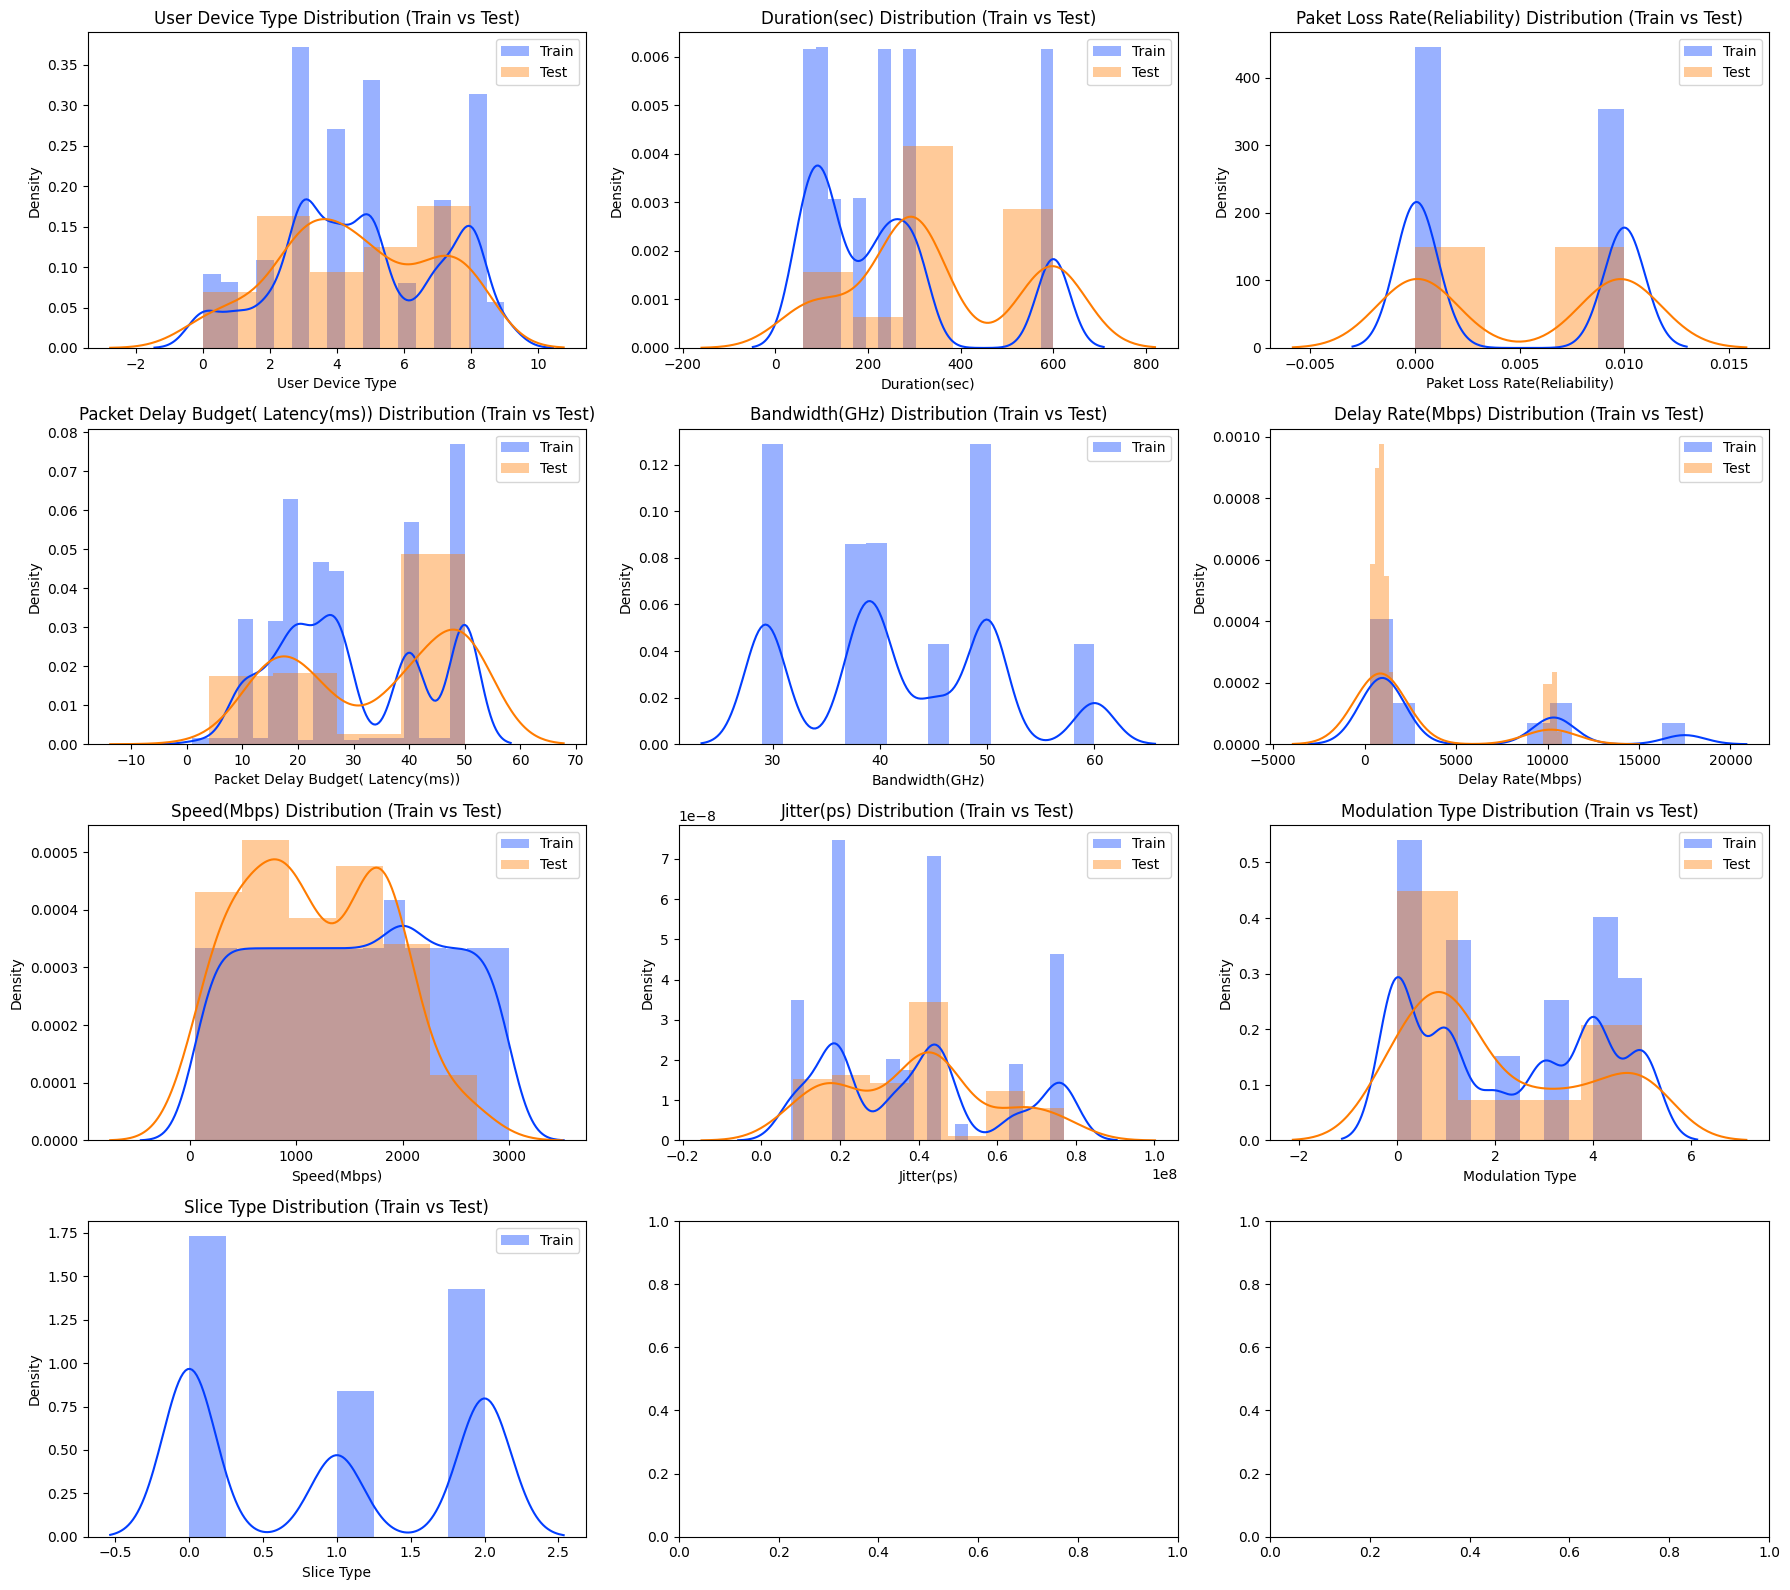

In [17]:
def plot_histograms(df_train, df_test, target, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target_1 and var_name != target_2:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train, test, target_1, n_cols=3)

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Additional Insights:<br><br>
+) From the above analysis, it can be seen that the dataset is imbalanced <br>

</b>
</p> 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">2. Bivariate Stats</p> 

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Recall: There are three types of bivariate analysis.</b><br>       
<ul> 
<li> <b>Numerical - Numerical: Pearson's Correlation</b> </li> <br>
The correlation represents the strength of a linear relationship between two numerical variables. If there is no correlation between the two variables, there is no tendency to change along with the values of the second quantity.  <br>  <br>
<li> <b>Categorical - Numerical: one-way ANOVA(3 + groups) or t-test (exactly 2 groups)</b>       </li> <br>
The ANOVA test is used to determine whether there is a significant difference among the averages of more than two groups that are statistically different from each other. <br><br>
<li> <b>Categorical - Categorical: Chi-square Test</b>       </li> <br>
It is calculated based on the difference between expected frequencies and the observed frequencies in one or more categories of the frequency table.
</ul>
</p> 

In [18]:
# this just an intermediate function that will be used in bivstats for one-way ANOVA
def anova(df, feature, label):
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])
        
    return stats.f_oneway(*group_labels)

# function to calculate bivariate stats; Pearson' correlation, p-value and one-way ANOVA
def bivstats(df, label):
    from scipy import stats
    import pandas as pd
    import numpy as np
    
    # Create an empty DataFrame to store output
    output_df = pd.DataFrame(columns=['Stat', '+1/-1 * ', 'Effect size', 'p-value'])
    
    for col in df:
        if col != label:
            if df[col].isnull().sum() == 0:
                if is_numeric_dtype(df[col]):   # Calculate r and p
                    r, p = stats.pearsonr(df[label], df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]
                    
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F, 3), round(p,6)]
                    
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, np.nan]

    return output_df.sort_values(by=['Effect size', 'Stat'], ascending=[False, False])
 
pd.options.display.float_format = '{:.5f}'.format

In [19]:
bivstats(train, target_1)

,Stat,+1/-1 *,Effect size,p-value
Modulation Type,r,-1.00000,0.29700,0.00000
User Device Type,r,1.00000,0.15200,0.00000
Duration(sec),r,-1.00000,0.02000,0.27243
Jitter(ps),r,-1.00000,0.01700,0.35925
Packet Delay Budget( Latency(ms)),r,-1.00000,0.01200,0.50061
Bandwidth(GHz),r,-1.00000,0.01000,0.58957
Speed(Mbps),r,-1.00000,0.00800,0.66002
Paket Loss Rate(Reliability),r,-1.00000,0.00300,0.85098
Delay Rate(Mbps),r,1.00000,0.00100,0.97095


In [20]:
bivstats(train, target_2)

,Stat,+1/-1 *,Effect size,p-value
Modulation Type,r,1.00000,0.06000,0.00092
Delay Rate(Mbps),r,1.00000,0.04000,0.02703
Duration(sec),r,-1.00000,0.03400,0.06509
Packet Delay Budget( Latency(ms)),r,-1.00000,0.01100,0.53996
Slice Type,r,-1.00000,0.01000,0.58957
User Device Type,r,1.00000,0.00400,0.81636
Speed(Mbps),r,1.00000,0.00400,0.81530
Jitter(ps),r,-1.00000,0.00400,0.81140
Paket Loss Rate(Reliability),r,-1.00000,0.00200,0.90660


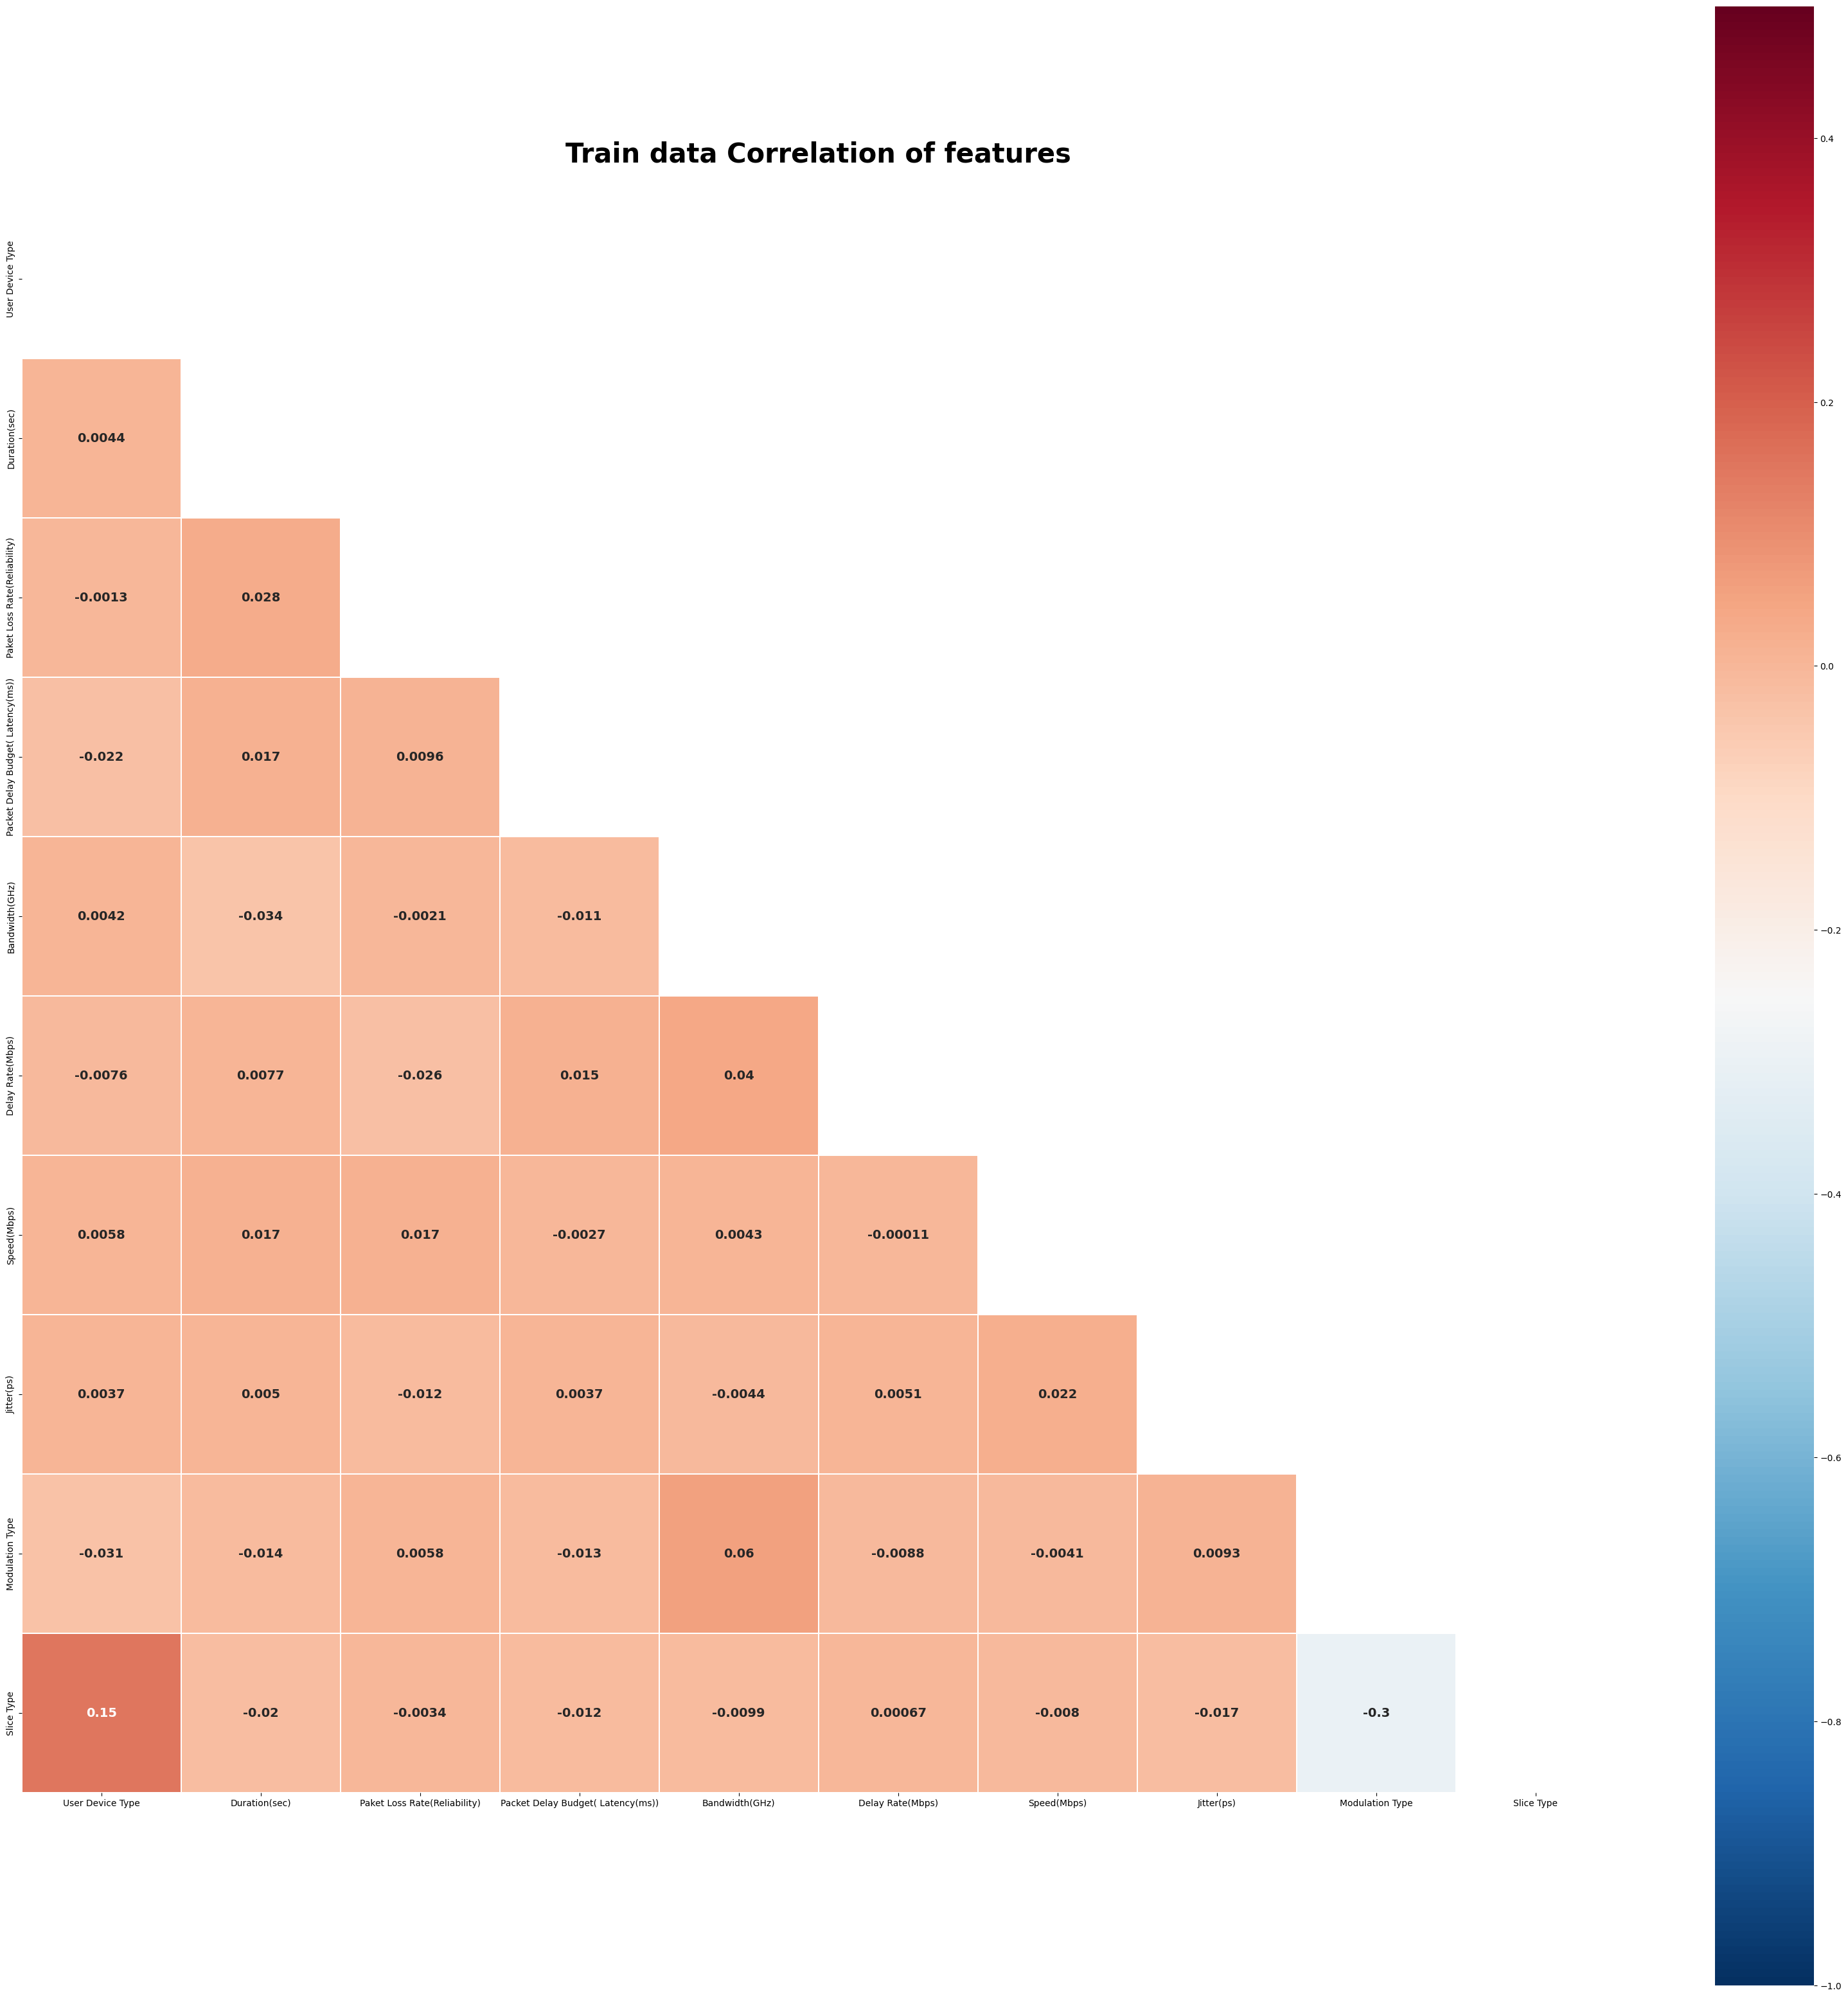

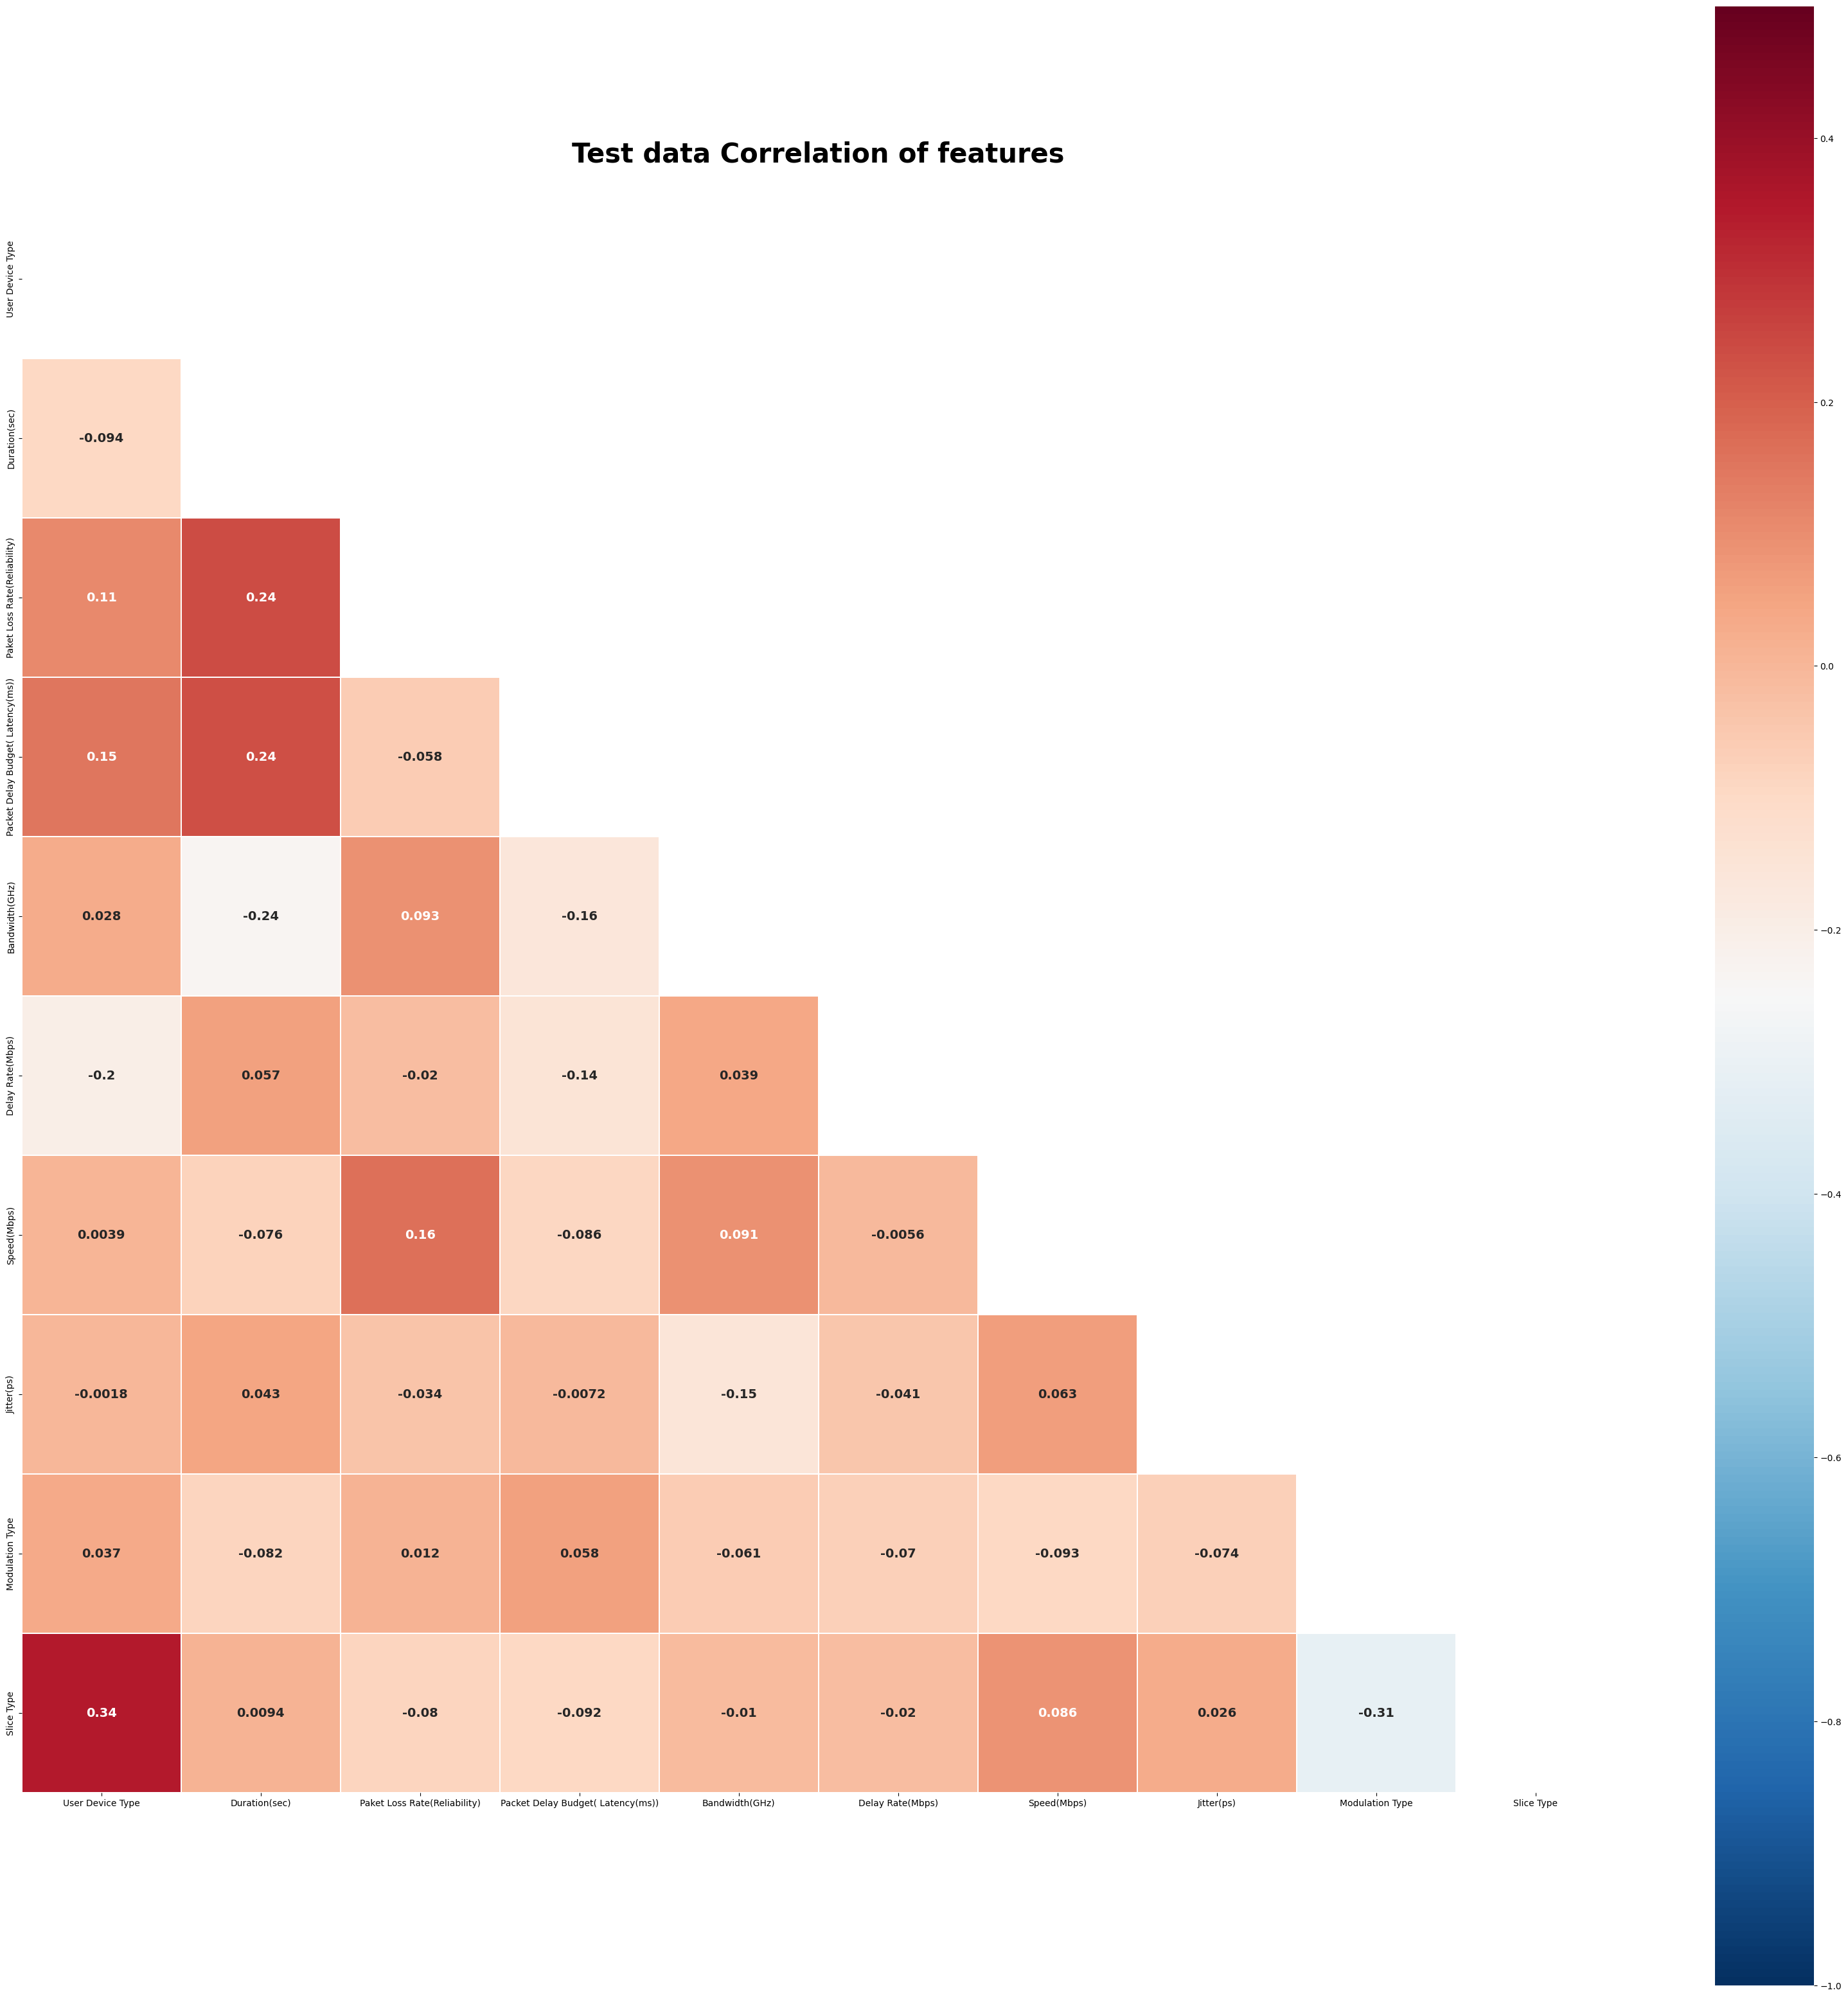

In [21]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(40, 40))

    # Set the title and font properties
    plt.title(f'{title} Correlation of features', fontweight='bold', y=1.02, size=30)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=0.5, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(train, title='Train data')
plot_heatmap(test, title='Test data')

In [22]:
train.columns

Index(['User Device Type', 'Duration(sec)', 'Paket Loss Rate(Reliability)',
       'Packet Delay Budget( Latency(ms))', 'Bandwidth(GHz)',
       'Delay Rate(Mbps)', 'Speed(Mbps)', 'Jitter(ps)', 'Modulation Type',
       'Slice Type'],
      dtype='object')

In [23]:
import seaborn as sns
import pandas as pd
import numpy as np

In [24]:
train.rename(
    columns={"User Device Type": "UserDeviceType", "Paket Loss Rate(Reliability)": "PacketLossRate", "Packet Delay Budget( Latency(ms))": "Latency","Bandwidth(GHz)":"Bandwidth","Delay Rate(Mbps)":"DelayRate","Speed(Mbps)":"Speed","Jitter(ps)":"Jitter","Modulation Type":"ModulationType","Slice Type":"SliceType"},
    inplace=True,
)

In [25]:
#Converting UserDevicType Column to numeric
train['UserDeviceType']= train['UserDeviceType'].map({'SmartPhone': 1, 'AR/VR/Gaming': 2, 'IOTDevices': 3, 'HealthCare': 4,
       'TansportationDevices': 5, 'PersonalComputers': 6, 'Industry': 7,
       'PublicSafetyDevices':8, 'CommunicationDevices':9, 'BlutoothDevices':10})

In [26]:
train = pd.read_csv("/kaggle/input/5g-dataset/5G_Dataset.csv")

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Encoding & Scaling: <br><br>
      

</b>
</p> 

In [36]:
categoric = ['User Device Type', 'Modulation Type', 'Slice Type']
for cat in categoric:
    print("Value count for: ", cat)
    print(train[cat].unique(), train[cat].nunique())

Value count for:  User Device Type
['SmartPhone' 'AR/VR/Gaming' 'IOTDevices' 'HealthCare'
 'TansportationDevices' 'PersonalComputers' 'Industry'
 'PublicSafetyDevices' 'CommunicationDevices' 'BlutoothDevices'] 10
Value count for:  Modulation Type
['FBMC' 'UFMC' 'GFDM' 'fOFDM' 'QAM' 'OFDM'] 6
Value count for:  Slice Type
['eMBB' 'URLLC' 'mMTC'] 3


In [38]:
train['Slice Type'] = train['Slice Type'].replace({'embb': 'eMBB', 'URLLC': 'URRLC'})

In [39]:
lb = LabelEncoder()
for cat in categoric:
    train[cat] = lb.fit_transform(train[cat])
train

,User Device Type,Duration(sec),Paket Loss Rate(Reliability),Packet Delay Budget( Latency(ms)),Bandwidth(GHz),Delay Rate(Mbps),Speed(Mbps),Jitter(ps),Modulation Type,Slice Type
0,8,600,0.01000,50,30,17500,1082,43000000.00000,0,1
1,8,100,0.01000,7,38,1700,2647,45000000.00000,0,1
2,8,240,0.00001,46,38,900,2821,65000000.00000,0,1
3,8,120,0.00010,12,50,900,864,77000000.00000,0,1
4,8,60,0.00000,49,60,1700,1945,33000000.00000,0,1
...,...,...,...,...,...,...,...,...,...,...
2995,1,180,0.01000,40,38,1700,1476,77000000.00000,1,2
2996,1,100,0.00001,28,29,300,512,10000000.00000,1,2
2997,1,180,0.00000,25,29,300,1752,65000000.00000,1,2
2998,1,300,0.00100,20,45,300,453,45000000.00000,1,2


In [40]:
y  = train[['Slice Type', 'Bandwidth(GHz)']]
X  = train.drop(columns=['Slice Type', 'Bandwidth(GHz)'], axis=1)

In [41]:
y.head()

,Slice Type,Bandwidth(GHz)
0,1,30
1,1,38
2,1,38
3,1,50
4,1,60


# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">IV. XGBoost Model building</p>

# **1. Basic Approach**

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state = 42)

In [43]:
basic_params = {
                 'tree_method': 'hist',
                 'max_depth': 4,
                 'reg_alpha': 1,
                 'reg_lambda': 5,
                 'min_child_weight': 3,
                 'gamma': 2,
                 'learning_rate': 0.160702260563716,
                 'eval_metric': 'auc',
                 'colsample_bytree': 0.77,
                 'colsample_bynode': 0.14,
                 'colsample_bylevel': 0.74,
                 'subsample': 0.95
                }

basic_classifier = MultiOutputClassifier(XGBClassifier(**basic_params))

basic_clf = Pipeline([
                # Add a transformer here
                ('classifier', basic_classifier)
               ])

#_ = basic_clf.set_params(**basic_params)

In [ ]:
basic_clf.fit(X_train, y_train)

# We'll predict the test data.
basic_preds = np.array(basic_clf.predict(X_val))
basic_preds